# __Group Project 4 - Team Luther Burbank__
<br>


### <span style = "color:dark">__Team Members: Yingyin Li, William Lee, Kanay Mathur, Kevin Kim, Qianhao (Harry) Zhong__
<br>



## **1. Project Topic & Goal:**

We intend to analyze the food demand system in Panama, evaluate the nutritional composition of various food items, and assess the nutritional sufficiency of households in Panama. Our objectives include establishing criteria for essential nutrients, identifying prevalent nutritional deficiencies, and examining challenges faced by Panamanian households in meeting recommended dietary intakes.
    
> * Preliminary findings suggest that a significant portion of Panamanian households exhibit deficiencies in essential nutrients such as vitamin A, vitamin C, and fiber, with a notable percentage failing to meet recommended daily intake levels. 
> * Furthermore, while carbohydrate consumption generally aligns with recommendations for most households, there exists a subset that surpasses the recommended intake. This excess intake may predispose individuals to issues such as caloric surplus, elevated blood glucose levels, and nutrient imbalances, warranting further investigation and intervention.*

<br>


## **2. Policy Exploration:**

Our policies are designed to elevate the nutritional quality of Panamanian households by targeting the attainment of vitamin and fiber sufficiency in two-thirds of the population. To realize these objectives, our strategies encompass:

>* Implementing food stamp programs or subsidies aimed at reducing the cost of high-vitamin and high-fiber foods in the market, particularly fruits and vegetables.
>* Providing subsidies to local restaurants contingent upon the adaptation of their menus to include a minimum of 70% items rich in vitamins and fiber.
>* Introducing tax incentives for farmers engaged in the production of fiber-rich foods, thereby encouraging the cultivation and availability of such dietary essentials.

<br>
    
## **3. Data(set) Description:**

> ####  __Main DataSet - [Panama Dataset](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103):__ This spreadsheet encompasses all the data we aim to manipulate. It contained subsheets titled <span style = "color:#0ED4F3"> <u>Household Characteristics, FCT (Food Composition Table), Food Expenditures, RDI (Recommended Dietary Intake), and Food Prices</span>.
> * #### __Subsheet 1 - [Household Characteristics](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=1095902684):__ This subsheet presents household data collected from multiple provinces in Panama, including Herrera, Bocas Del Toro, Chiriquí, Colón, and Panamá, spanning the years 1997 to 2008. It offers a detailed breakdown of household composition by gender and age group across these provinces, providing insight into the demographic diversity within the surveyed regions over the specified timeframe.
> * #### __Subsheet 2 - [FCT](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=881999882):__ This sheet provides a comprehensive overview of the nutritional content of different foods per 100 grams of edible portion. Each row corresponds to a specific food item, while the columns contain data regarding its water content, energy value, macronutrient composition, and other nutritional components.
> * #### __Subsheet 3 - [Food Expenditures](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103):__ This dataset is structured as a multi-indexed dataset, featuring information on food expenditure across diverse households. The indexing incorporates three levels: year, region, and household identifier. This hierarchical organization facilitates systematic analysis, enabling examination of fluctuations in food expenditure over time, disparities across geographical regions, and variations among individual households.
> * #### __Subsheet 4 - [Food Prices](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=1029038038):__ This spreadsheet seems to comprise a collection of food items alongside their prices and measurements across different regions and time periods in Panama. Each row likely represents a unique food item and its corresponding measurement, while each column denotes various regions or time periods. The values within each cell likely indicate the corresponding price and unit of measurement for the specified region or period, providing a comprehensive overview of food prices and availability over time and across different geographical areas within Panama.
> * #### __Subsheet 5 - [RDI](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=342562131):__ This sheet outlines recommended daily intake levels of various nutrients for different age and gender groups. It spans from infancy to older adulthood, detailing values for nutrients such as Energy, Protein, Fiber, Folate, Calcium, and more. Each demographic group, categorized by age and gender, has specific recommended intake levels for optimal nutrition.

<br>

## **4. Project Deliverables:**

### *Packages Import*:

In [1]:
# The lengthy output has been hidden
# Try to re-run this code if you encounter "ERROR: pip's dependency resolver does not currently take into account all the packages that are installed."
!pip install -r requirements.txt -q
!pip install CFEDemands --upgrade --pre -q
!pip install eep153_tools --upgrade -q

In [2]:
from cfe.estimation import drop_columns_wo_covariance
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt
from cfe import Regression
from cfe import regression as rgsn
import numpy as np
import pandas as pd
import cfe
import warnings

<br>

### *DATA Import, DATA Cleaning*:

In [3]:
InputFiles = {"Expenditures": ("1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE", "Food Expenditures"),
              'Prices':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','Food Prices'),
              'HH Characteristics':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','Household Characteristics'),
              'FCT':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','FCT'),
              'RDI':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','RDI')}

In [4]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

In [5]:
################# Get expenditures #################
Expenditures = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in Expenditures.columns:  # If Expenditures doesn't include column "m", create one manually.
    Expenditures['m'] = 1
    
Expenditures = Expenditures.set_index(['i','t','m'])
Expenditures.columns.name = 'j'

Expenditures = Expenditures.apply(lambda x: pd.to_numeric(x,errors='coerce'))
Expenditures = Expenditures.replace(0,np.nan)  # Convert all zeros to NaN


################# Get HH characteristics #################
HH_characteristics = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in HH_characteristics.columns:
    HH_characteristics['m'] = 1

HH_characteristics = HH_characteristics.set_index(['i','t','m'])
HH_characteristics.columns.name = 'k'  # Assign a overarching column name to coloumn indexes

HH_characteristics = HH_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))



################# Get prices #################
price_url = 'https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103'

prices = read_sheets(price_url, sheet='Food Prices', nheaders=2)
prices.columns.names = ['t', 'm']  # Assign two column names to two headers
# since there are multiple prices for food in various sizes, we choose to use average price 
prices.groupby(level='j').mean()
prices=prices.transpose()
if 'm' not in prices.columns:  # Supply "market" indicator if missing
    prices['m'] = 1  
prices = prices.apply(lambda x: pd.to_numeric(x,errors='coerce'))
prices = prices.replace(0,np.nan)



################# fct #################
fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))



################# RDI, if available (consider using US) #################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.set_index('n')
rdi.columns.name = 'k'
new_column_names = [
"Females 00-03", "Males 00-03", "Females 04-08", "Males 04-08", "Females 09-13", "Males 09-13", 
    "Females 14-18", "Males 14-18",  "Females 19-30", "Males 19-30", "Females 31-50", "Males 31-50",  "Females 51-99", "Males 51-99"]
column_name_mapping = {old: new for old, new in zip(rdi.columns, new_column_names)}
rdi.rename(columns=column_name_mapping, inplace=True)

### From above, we get "Expenditures", "HH_characteristics", "prices", "fct", "rdi"

<br>

### *Cleaned DataFrame Display*:

In [6]:
Expenditures.head()

,,j,Aceite Vegetal,Aguacates,Ahí Verde,Ajo,Alimento Infantil,Apio,Arroz,Arvejas,Azúcar,Café Y Té,...,"Sodas, Refrescos Y Jugos",Sopa Enlatada,Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame
i,t,m,,,,,,,,,,,,,,,,,,,,,
19971000,1997,Chíriqui,6.0,NaN,0.5,NaN,2.7,0.3,7.25,NaN,1.6,NaN,...,8.0,0.7,NaN,NaN,NaN,NaN,NaN,0.8,NaN,0.4
19971001,1997,Chíriqui,NaN,NaN,NaN,NaN,NaN,NaN,4.80,NaN,NaN,1.4,...,1.5,NaN,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN
19971002,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,6.00,NaN,2.0,3.6,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
19971003,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971005,1997,Chíriqui,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,1.5,...,NaN,0.7,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [7]:
HH_characteristics.head()

,,k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1.098612
1997160,1997,Herrera,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1.098612
1997170,1997,Bocas Del Toro,1,3,1,4,1,2,1,0,0,1,1,1,0,0,0,1,1,0,2.197225
1997177,1997,Bocas Del Toro,4,9,1,5,2,1,4,1,1,3,2,0,0,2,0,2,1,0,2.944439
1997178,1997,Bocas Del Toro,2,1,2,2,0,0,0,1,1,0,0,1,2,0,0,1,0,1,1.945910


In [8]:
prices.head()

j                   Aceite Vegetal                                            \
u                       1/2 gallon  None bottle    can gallon gram large bay   
t    m                                                                         
1997 Bocas Del Toro          3.225   NaN   1.20  2.975   6.70  NaN     1.500   
     Chíriqui                3.250  0.10   1.35    NaN   5.95  NaN     1.350   
     Coclé                   2.990  0.10   1.30    NaN   5.90  NaN     1.375   
     Colón                   3.250  0.10   1.34    NaN   5.75  NaN       NaN   
     Darién                  3.200  0.25   1.40    NaN   4.85  NaN     1.525   

j                                                ... Zapallo / Chayote  \
u                   liter medium bar milliliter  ...              unit   
t    m                                           ...                     
1997 Bocas Del Toro   NaN      1.050        NaN  ...              0.10   
     Chíriqui         NaN      1.325        NaN  ...              0.10   
     Coclé            NaN      1.275        NaN  ...              0.15   
     Colón            NaN      0.850        NaN  ...              0.25   
     Darién           NaN      1.400        NaN  ...               NaN   

j                                    Ñame                                 \
u                       value bag or sack gram ounce package pound  unit   
t    m                                                                     
1997 Bocas Del Toro       NaN         3.6  NaN   NaN     NaN  0.40   NaN   
     Chíriqui        0.084416         NaN  NaN   NaN     NaN  0.40  0.15   
     Coclé           0.201299         NaN  NaN   NaN     NaN  0.50  0.50   
     Colón           0.045455         NaN  NaN   NaN     NaN  0.40  0.60   
     Darién               NaN         NaN  NaN   NaN     NaN  0.15   NaN   

j                              m  
u                       value     
t    m                            
1997 Bocas Del Toro       NaN  1  
     Chíriqui        0.038961  1  
     Coclé                NaN  1  
     Colón           0.064935  1  
     Darién               NaN  1  

[5 rows x 691 columns]

In [9]:
fct.head()

n,Agua,Energía,Proteina,Grasa Total,Carbo-hidratos,Fibra Diet. total,Ceniza,Calcio,Fosforo,Hierro,...,Colesterol,Potasio,Sodio,Zinc,Magnesio,Vit. B6,Vit. B12,Ac. Fólico,Folato Equiv. FD,Fracción Comestible
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Aguacates,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Ahí Verde,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Ajo,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Alimento Infantil,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00


In [10]:
rdi.head()

k,Females 00-03,Males 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


<br>


## __[A] Estimate Demand System__

* ### *Main Demand System Regression Equation:*

<br>

$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
<br>

> $y_{i}^j$ : *__Logarithmic expenditures on food $j$ by household $i$ at a particular time.__*
> 
> $A^j(p)$ : *__Sub-function of price $p$ of food $j$. It captures the demand elasticity of food $j$ .__*
>
> $\gamma_j'd_i$ : *__Variable $d_i$ represents household characteristics. The coefficient $\gamma_j'$ signifies how food expenditure changes in response to variations in household composition.__*
>
> $\beta_j w_i$ : *__Variable $w_i$ represents household wealth. The coefficient $\beta_j$ indicates how changes in household wealth affect food expenditure.__*
>
> $\zeta^j_i$ : *__The error term represents all sources of variation in the dependent variable ($y_{i}^j$) that are not explained by the independent variables included in regression function.__*

* ### *To enhance the accuracy of our demand prediction model given limited data, we broke down the main equation into a sub-equation comprising two available variables. We then conducted regression analysis, correlating food expenditure with household composition (characteristics) and food prices:*

<br>

$$
      y^j_{i} = \gamma_j'd_i + A^j(p) + \zeta^j_i.
$$
<br>

* ### *Integrating household characteristics with food prices yields valuable insights into the factors shaping household spending on various food items. This amalgamation enables the analysis of correlations between household demographics, such as size, and external factors like food prices across specific regions and years.*

> __This merged dataset facilitates addressing inquiries such as:__
> - __*How do fluctuations in food prices influence household expenditures on different food items?*__
> - __*Do variations in household size or composition lead to differences in food purchasing patterns?*__
> - __*Which food items exhibit greater sensitivity to price fluctuations, and how does this sensitivity vary across regions and demographic groups?*__

<br>



In [11]:
# Combining prices_pound and HH_characteristics_1
price_url = 'https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103'
prices_1 = read_sheets(price_url, sheet='Food Prices', nheaders=2)
prices_pound = prices_1.loc[(slice(None), "pound"), :].T  # Filter out all rows that don't have column value "pound" and make it a new dataframe


# Dataframe Formatting for prices_value
prices_pound.columns.names = ['w', 'm']
prices_pound = prices_pound.droplevel('m', axis=1)
prices_pound = prices_pound.T
prices_pound.columns.names = ['t', 'm']
prices_pound = prices_pound.T
prices_pound.index = prices_pound.index.set_levels(prices_pound.index.levels[0].astype(int), level=0)  # Convert year of string type to numeric one.
prices_pound


# Dataframe Formatting for HH_characteristics
HH_characteristics_1 = HH_characteristics.T
HH_characteristics_1 = HH_characteristics_1.droplevel('i', axis=1)
HH_characteristics_1 = HH_characteristics_1.T
HH_characteristics_1


# Combine two Dataframe by matching multi-index
merged_df = pd.merge(HH_characteristics_1, prices_pound, left_index = True, right_index = True, how='left')
merged_df.fillna(0, inplace=True)


# Put the previously-removed household id back to the Dataframe
column_i = HH_characteristics.index.get_level_values('i')
column_i_df = pd.DataFrame(column_i, columns=['i'])
merged_df.reset_index(inplace=True)  # Add index manually


# Final Dataset Formatting
merged_df = pd.concat([column_i_df, merged_df], axis = 1)
merged_df = merged_df.set_index(['i','t','m'])
merged_df.columns.name = 'k'
merged_df.head()

,,k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,...,Segundo otro,"Sodas, Refrescos Y Jugos",Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame
i,t,m,,,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.5,1.25,1.1,0.15,0.5,0.2,0.4
1997160,1997,Herrera,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,1.25,1.1,0.15,0.5,0.2,0.4
1997170,1997,Bocas Del Toro,1.0,3.0,1.0,4.0,1.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.7,1.20,0.5,0.20,0.6,0.3,0.4
1997177,1997,Bocas Del Toro,4.0,9.0,1.0,5.0,2.0,1.0,4.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.7,1.20,0.5,0.20,0.6,0.3,0.4
1997178,1997,Bocas Del Toro,2.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.7,1.20,0.5,0.20,0.6,0.3,0.4


<br>

* ### *Regression Setup, Result Saving and Result Overview*

In [12]:
# To enhance the model's accuracy, we may encounter foods with very low consumption rates, making it challenging to reliably estimate their demand. 
# We can adjust the min_obs parameter; increasing its value will result in dropping more foods from the analysis.
# Expenditures = drop_columns_wo_covariance(Expenditures,min_obs=30)

# Take the logarithm to Expenditures. 
Expenditures_log = np.log(Expenditures)
use = Expenditures_log.index.intersection(merged_df.index)
Expenditures_log = Expenditures_log.loc[use,:]
merged_df_matched = merged_df.loc[use,:]

Expenditures_log = Expenditures_log.stack()
merged_df_matched = merged_df_matched.stack()

# Check that indices are in right places.
assert Expenditures_log.index.names == ['i','t','m','j']
assert merged_df_matched.index.names == ['i','t','m','k']

# Remove Ruplicated Indexes.
Expenditures_log = Expenditures_log.groupby(level = Expenditures_log.index.names).mean()

### Regession SetUp
result = Regression(y = Expenditures_log,d = merged_df_matched)

In [13]:
# Save and reload result
result.to_pickle('pj4_estimate_result.pickle')
result = cfe.regression.read_pickle('pj4_estimate_result.pickle')

In [14]:
## This code may take longer than 2 minutes to process.
xhat = result.predicted_expenditures()
xhat

i         t     m                    j                        
20081     2008  Bocas Del Toro       Aceite Vegetal               5.288339
                                     Ajo                          0.692437
                                     Arroz                        7.311953
                                     Azúcar                       3.079029
                                     Café Y Té                    2.596964
                                                                    ...   
20087040  2008  Comarca Ngobe Bugle  Queso (Blanco Y Amarillo)    1.747443
                                     Raspados Y Duros             1.359181
                                     Sal                          0.618434
                                     Sardina Y Atún               3.677415
                                     Sodas, Refrescos Y Jugos     2.659700
Length: 416806, dtype: float64

<br>

### 📈📊 *__Regression Result Analytics [I] - Model Accuracy:__*

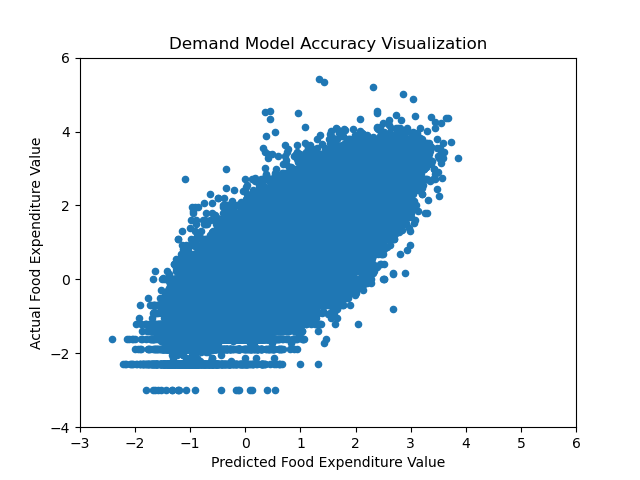

In [15]:
# Compare predicted logarithmic expenditures with actual expenditures:
%matplotlib widget
df = pd.DataFrame({'y':Expenditures_log, 'yhat':result.get_predicted_log_expenditures()})
ax = df.plot.scatter(x='yhat',y='y')

# Set the x-axis limits from -3 to 6 and the y-axis limits from -4 to 6
ax.set_xlim(-3, 6) 
ax.set_ylim(-4, 6)
plt.xlabel("Predicted Food Expenditure Value")
plt.ylabel("Actual Food Expenditure Value")
plt.title("Demand Model Accuracy Visualization")
plt.show()

# # Plot a trendline
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax], color = 'Salmon')

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*The figure above presents a scatter plot juxtaposing the predicted food expenditures derived from our regression model against the actual logarithmic food expenditures.*__
* <span style = "color:#1FF30E">__*The depiction indicates a better level of predictive capability and accuracy within the model after combining the food prices with household characteristics.*__

In [16]:
# Our predicted result
regression_result = result.gamma

# Seperate the result into prices part and HH_characteristics part
HH_char_regression_result = regression_result.iloc[:, :19]  # First two columns
prices_regression_result = regression_result.iloc[:, 19:]  # Remaining columns

<br>

### 📈📊 *__Regression Result Analytics [II] - Coefficients of Household Characteristics:__*

In [17]:
HH_char_regression_result.head()

k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
j,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,-0.279741,-0.024983,-0.024060,-0.313845,-0.071561,0.201712,-0.035537,0.245528,-0.030347,0.254907,-0.011576,0.271751,0.010277,0.300921,0.035420,0.362683,0.054342,0.305659,0.343150
Ajo,0.134699,-0.030682,-0.006343,0.100107,-0.027076,-0.166284,-0.048766,-0.162973,-0.006369,-0.138375,-0.003593,-0.116260,-0.009174,-0.131387,0.015281,-0.083056,0.042628,-0.089703,0.190649
Arroz,-0.490754,-0.301524,-0.285209,-0.429082,0.251868,0.355174,0.255758,0.396293,0.323543,0.446158,0.386822,0.448854,0.348911,0.454263,0.376193,0.416498,0.374652,0.441405,0.583224
Azúcar,-0.172819,-0.409167,-0.447934,-0.141708,0.418831,0.165032,0.424705,0.162971,0.447470,0.186949,0.490488,0.176532,0.474475,0.171011,0.506233,0.190854,0.568229,0.224298,0.359284
Café Y Té,0.074437,0.040152,0.081201,0.055541,-0.036127,-0.041840,-0.019825,-0.039572,-0.003977,-0.046544,-0.011789,-0.007314,-0.019644,-0.032832,0.068431,0.051626,0.144316,0.101503,-0.030925


### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*Each cell in the table above corresponds to the coefficient of household characteristics in our regression model, representing the sought-after outcome of our regression analysis.*__
* <span style = "color:#1FF30E">__*For example, in the first cell, a value of -0.279741 signifies the average reduction in <u>"Aceite Vegetal" (Vegetable oil) </u>consumption by 0.279741 units for each additional woman in a Panamanian household.*__

Please choose from the following:
"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",
 "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"




Please input the first population group you would like to visualize (No quotation mark required):  boys


Please input a population group you would like to visualize and compare with the first chosen one (No quotation mark required):  girls


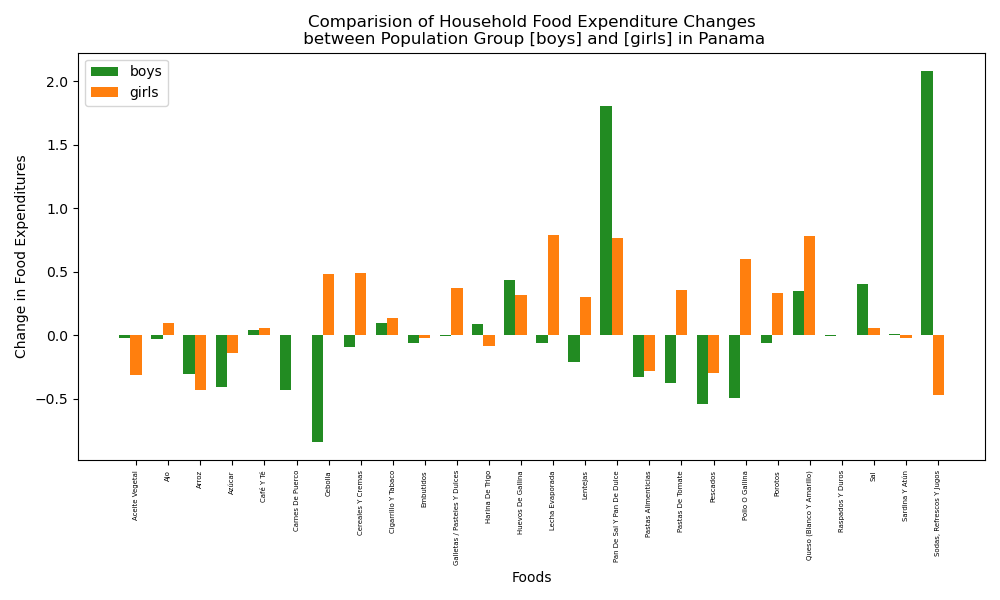

In [18]:
def plot_two_gamma_table(gamma_table, population_groups):
    """
    Ths function is designed to help combine two bar charts displaying food expenditure changes with variations of household composition, and do the comparision.
    
    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (list): It should be a list of two population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.7 
    num_groups = len(population_groups)
    bar_width = width / num_groups  # Adjusting the bar width for multiple groups
    colors = ['#228b22', '#ff7f0e']
    for i, population_group in enumerate(population_groups):
        x = range(len(gamma_table.index))
        ax.bar([pos + i * bar_width for pos in x], gamma_table[population_group], bar_width, label=population_group, color=colors[i])

    ax.set_title(f'Comparision of Household Food Expenditure Changes\n between Population Group [{population_groups[0]}] and [{population_groups[1]}] in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    ax.set_xticks([pos + width / 2 for pos in x])
    ax.set_xticklabels(gamma_table.index, rotation=90, fontsize=5)
    ax.legend()
    plt.tight_layout()
    plt.show()

print('Please choose from the following:\n"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",\n "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"')
print("\n")  
population_input_list_1 = input('Please input the first population group you would like to visualize (No quotation mark required): ')
print("\n")  
population_input_list_2 = input('Please input a population group you would like to visualize and compare with the first chosen one (No quotation mark required): ')

population_groups = [population_input_list_1, population_input_list_2]  # List of population groups
plot_two_gamma_table(HH_char_regression_result, population_groups)

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*Using women and men as examples, notable observations extend beyond the straightforward comparison of bar lengths in the figure.*__
* <span style = "color:#1FF30E">__*For instance, a distinct contrast in <u>"Cebolla" (onion) </u> consumption between genders within households is apparent: men tend to decrease <u>"Cebolla" (onion) </u> consumption, while women in the same age group tend to increase it. This highlights potential policy disparities related to gender or age groups.*__
* <span style = "color:#1FF30E">__*Additionally, exploring exceptionally long bars, such as men's consumption in <u>"Sodas, Refrescos Y Jugos" (Sodas, Soft Drinks, and Juices) </u> and <u>"Pan De Sal Y Pan De Dulce" (Bread of salt and sweet bread) </u>, could provide valuable insights.*__

<br>

### 📈📊 *__Regression Result Analytics [III] - Coefficients of Food Prices:__*

In [19]:
prices_regression_result.head()

k,Aceite Vegetal,Aguacates,Ahí Verde,Ajo,Alimento Infantil,Apio,Arroz,Arvejas,Azúcar,Café Y Té,...,"Sodas, Refrescos Y Jugos",Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame,Constant
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,-0.001241,-0.016810,-0.025335,0.004144,0.017073,0.010389,-0.033659,0.087125,-0.028095,0.047637,...,0.012795,-0.000315,-0.012326,0.047533,-0.060228,-0.021808,-0.004330,0.026575,-0.003108,0.972191
Ajo,0.014903,0.047968,0.013298,0.019184,0.011361,0.056710,-0.026226,0.094688,-0.026108,-0.034861,...,0.015123,-0.021128,-0.009380,0.083253,-0.041831,-0.019231,0.041310,0.045132,-0.071264,-0.705411
Arroz,-0.047629,-0.082647,0.036117,-0.106677,0.042368,0.102656,-0.055984,0.084943,-0.066986,0.161504,...,-0.000810,-0.033264,-0.035187,0.114653,0.015350,-0.062325,0.054912,0.019693,0.026250,1.795121
Azúcar,0.004040,0.044835,0.023544,0.046919,-0.013001,0.003088,0.016152,0.014800,0.016825,-0.141494,...,0.010793,0.006333,0.009447,0.033140,-0.004351,0.019551,0.028921,0.005282,-0.228793,0.413226
Café Y Té,-0.064845,0.021321,-0.001064,0.033444,-0.067615,0.017714,-0.023030,0.028719,-0.017139,0.024415,...,-0.034749,0.026148,0.001064,0.076720,-0.077895,-0.010863,0.004271,0.044555,0.122897,0.498355


### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*The table above resembles an economic demand system, where each cell represents the change in consumption of a specific type of food given a one-unit increase in the price per pound.*__
* <span style = "color:#1FF30E">__*For instance, in the first cell with a value of -0.001241, for every one-unit increase in the price per pound of <u>"Aceite Vegetal" (vegetable oil)</u>, households are expected to reduce their consumption of <u>"Aceite Vegetal"</u> by 0.001241 units.*__
* <span style = "color:#1FF30E">__*However, due to data limitations, we only have food prices for 1997 and 2003, and thus, we lack the full range of price changes for specific foods. Consequently, we cannot directly correlate this data with the formal economic demand trend in price-quantity coordinates.*__

Please choose from the following:
'Aceite Vegetal', 'Ajo', 'Arroz', 'Azúcar', 'Café Y Té','Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas','Cigarrillo Y Tabaco', 'Embutidos', 'Galletas / Pasteles Y Dulces','Harina De Trigo', 'Huevos De Gallina', 'Lecha Evaporada', 'Lentejas','Pan De Sal Y Pan De Dulce', 'Pastas Alimenticias', 'Pastas De Tomate','Pescados', 'Pollo O Gallina', 'Porotos', 'Queso (Blanco Y Amarillo)','Raspados Y Duros', 'Sal', 'Sardina Y Atún','Sodas, Refrescos Y Jugos'




Please input the first food you would like to visualize (No quotation mark required):  Aceite Vegetal


Please input the food you would like to visualize and compare with the first chosen one (No quotation mark required):  Azúcar


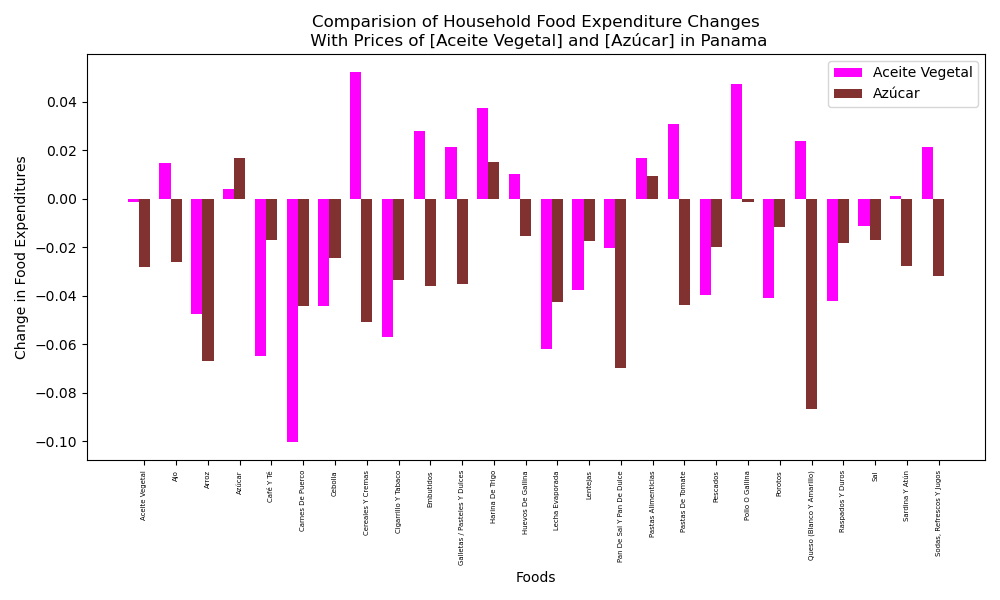

In [20]:
def plot_two_gamma_table(gamma_table, population_groups):
    """
    Ths function is designed to help combine two bar charts displaying food expenditure changes with variations of household composition, and do the comparision.
    
    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (list): It should be a list of two population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.7 
    num_groups = len(population_groups)
    bar_width = width / num_groups  # Adjusting the bar width for multiple groups
    colors = ['#FF00FF', '#823131']
    for i, population_group in enumerate(population_groups):
        x = range(len(gamma_table.index))
        ax.bar([pos + i * bar_width for pos in x], gamma_table[population_group], bar_width, label=population_group, color=colors[i])

    ax.set_title(f'Comparision of Household Food Expenditure Changes\n With Prices of [{population_groups[0]}] and [{population_groups[1]}] in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    ax.set_xticks([pos + width / 2 for pos in x])
    ax.set_xticklabels(gamma_table.index, rotation=90, fontsize=5)
    ax.legend()
    plt.tight_layout()
    plt.show()

print("Please choose from the following:\n'Aceite Vegetal', 'Ajo', 'Arroz', 'Azúcar', 'Café Y Té','Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas','Cigarrillo Y Tabaco', 'Embutidos', 'Galletas / Pasteles Y Dulces','Harina De Trigo', 'Huevos De Gallina', 'Lecha Evaporada', 'Lentejas','Pan De Sal Y Pan De Dulce', 'Pastas Alimenticias', 'Pastas De Tomate','Pescados', 'Pollo O Gallina', 'Porotos', 'Queso (Blanco Y Amarillo)','Raspados Y Duros', 'Sal', 'Sardina Y Atún','Sodas, Refrescos Y Jugos'")
print("\n")  
population_input_list_1 = input('Please input the first food you would like to visualize (No quotation mark required): ')
print("\n")  
population_input_list_2 = input('Please input the food you would like to visualize and compare with the first chosen one (No quotation mark required): ')

population_groups = [population_input_list_1, population_input_list_2]  # List of population groups
plot_two_gamma_table(prices_regression_result, population_groups)

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*This visualization of the table allows us to compare the price sensitivity of different foods and their related counterparts.*__
* <span style = "color:#1FF30E">__*Taking the longest bar as an example, both <u>"Arroz" (rice) </u> and <u>"Ajo" (garlic) </u> exhibit a decrease in consumption as the price of <u> "Pan De Sal Y Pan De Dulce" (Bread of salt and sweet bread) </u> increases. However, it's evident that <u>"Ajo" </u>is approximately five times more sensitive than <u> "Arroz" </u>, as indicated by the significantly longer bar.*__
* <span style = "color:#1FF30E">__*Zooming out and examining the overall graph, you might notice that for most pairs of bars, <u> "Ajo" </u> consistently exhibits longer bars than <u>"Arroz"</u>. In other words, <u>"Arroz" (rice)</u> is more "inelastic" to price changes compared to foods related to <u>"Ajo" (garlic) </u>. This suggests the potential for tailored policy interventions for these two typical food types.*__

In [21]:
# Avoid Memory Overload
# plt.close('all')

# Change Dataframe display setting
# pd.options.display.max_rows = 1000 

### Demand Curve 

In [27]:
# demand curve for rice

# Implied relative prices
p_result = np.exp(result.get_Ar())

import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Arroz'  # Put the food item that we want demand curve for here. 
               # 'Arroz' is translated to 'rice' in English. 

# Generates an array of 20 evenly spaced numbers from 0.5 to 2.
scale = np.linspace(.5,2,20)

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

# Reference prices - Calculate the average price for each food item across all observations.
pbar = p_result.groupby(level='j').mean()

def my_prices(p0, p = pbar, j = 'Arroz'):
    """
    This changes the food prices of good j while holding other food prices unchanged
    
    p0 - The price you want to change
    p - The price dataframe you want to make changes
    j - The specific food that you want to make changes in their price.
    """
    p_copy = p.copy()
    p_copy.loc[j] = p0
    return p_copy


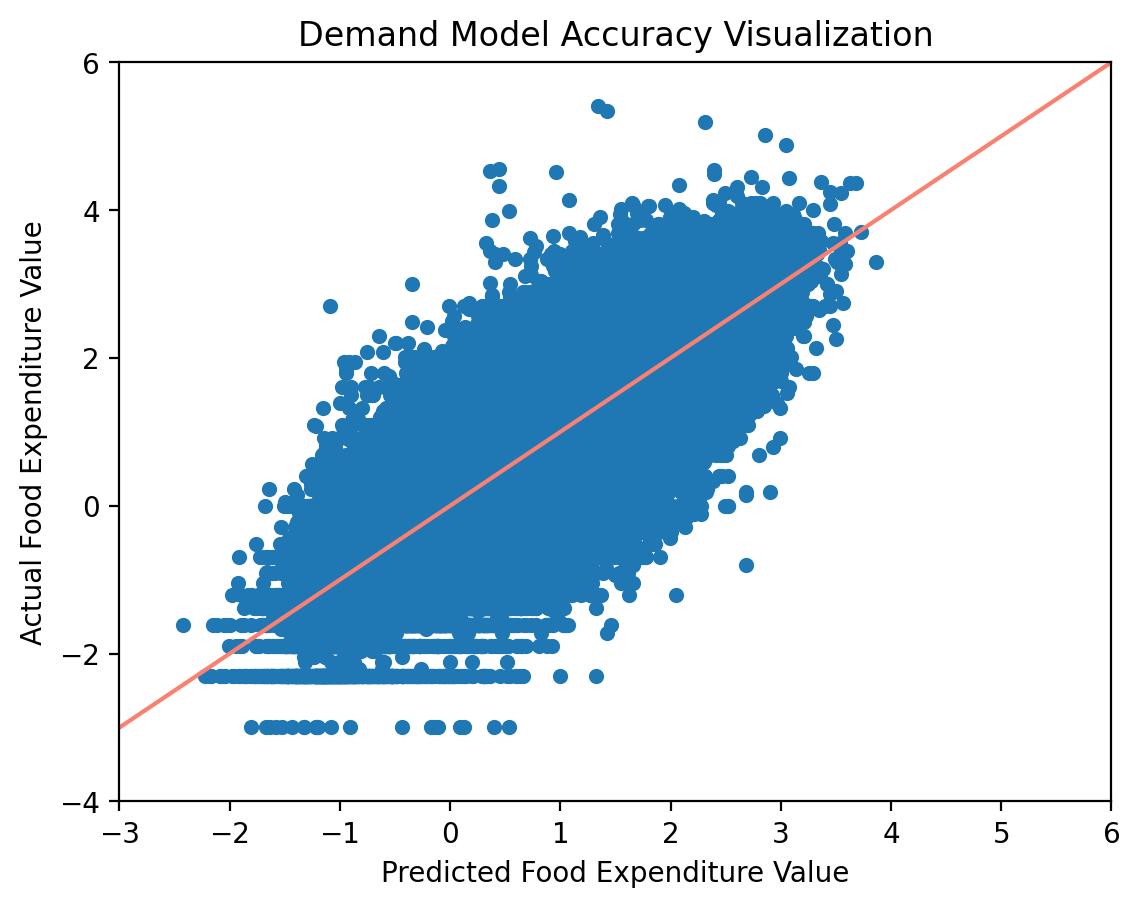

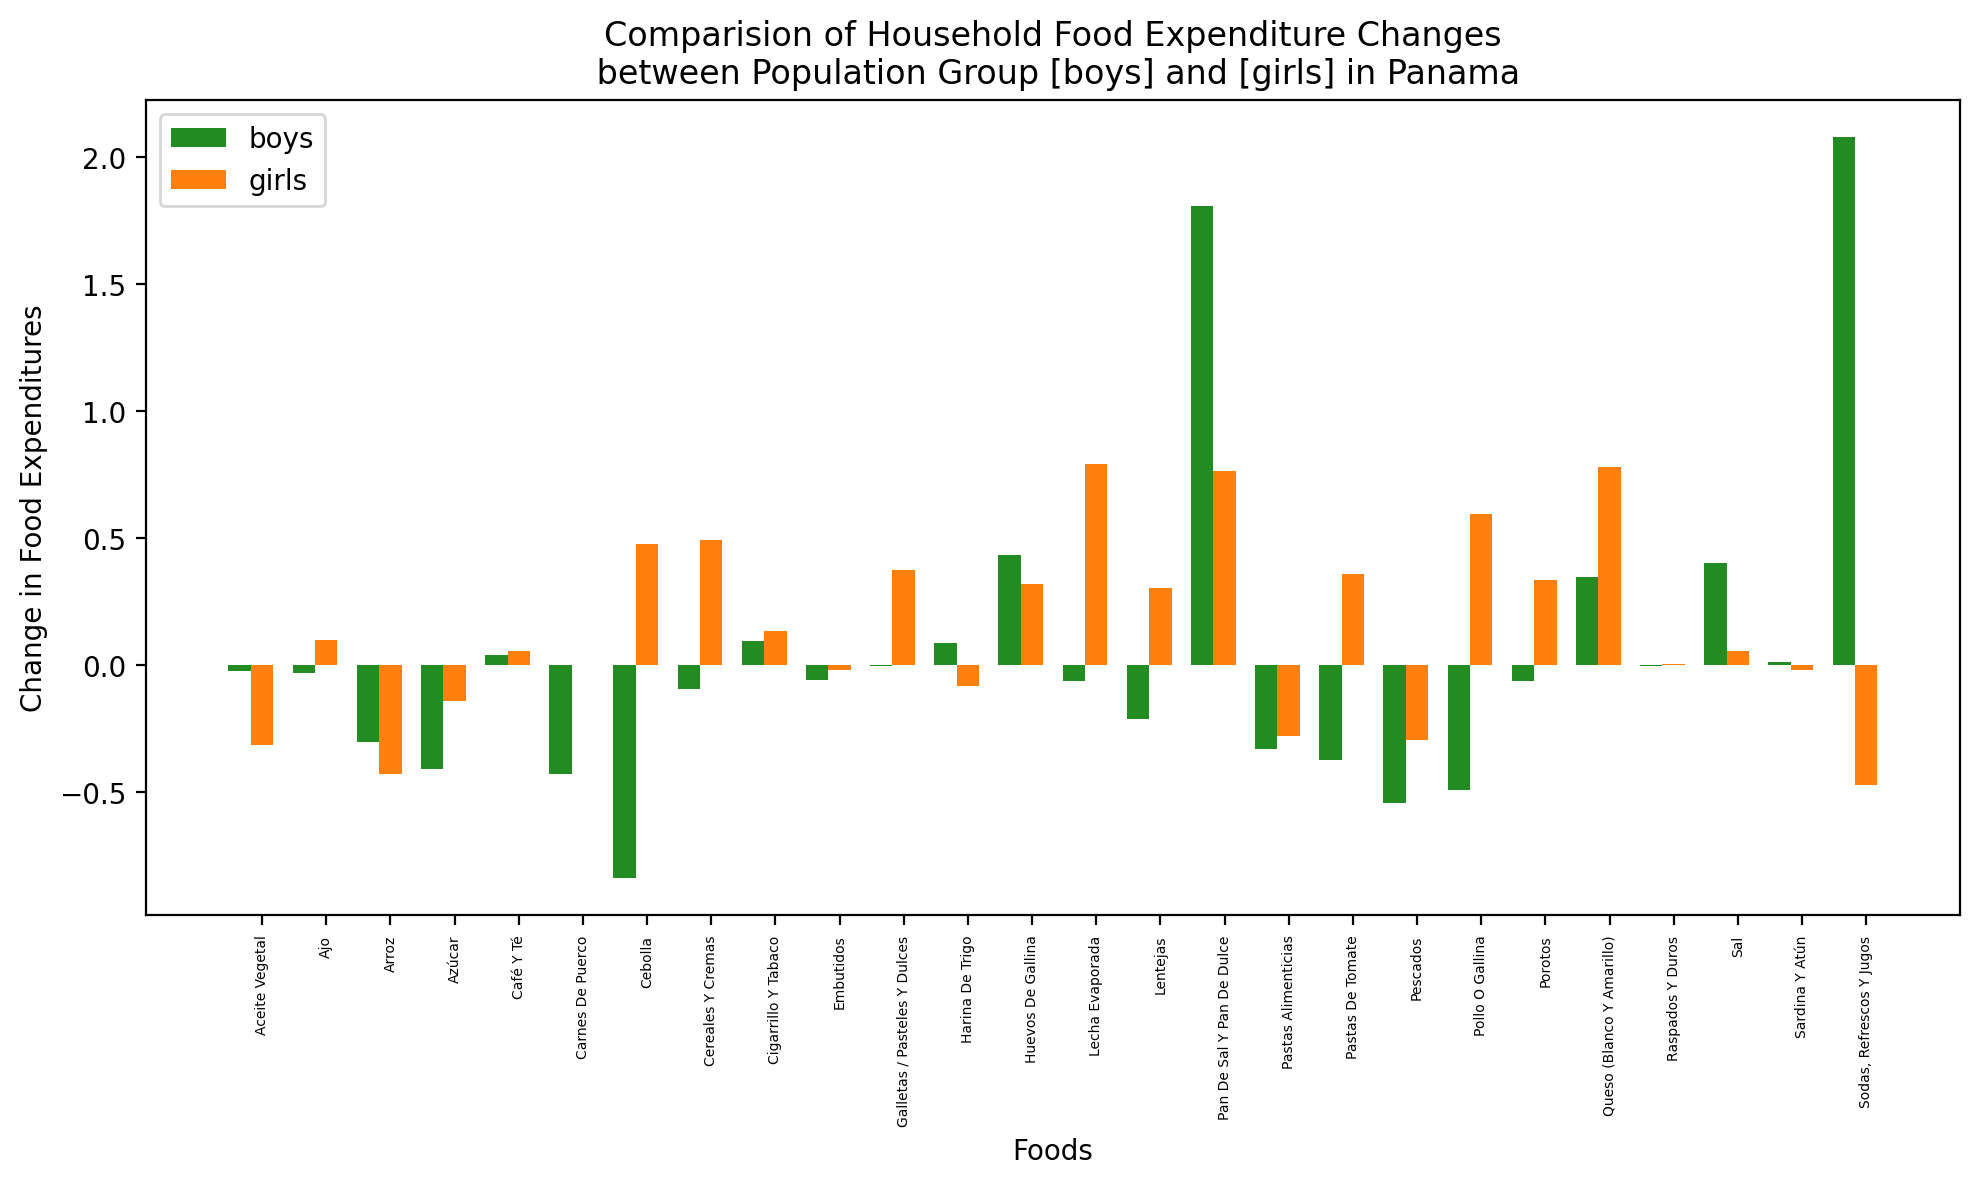

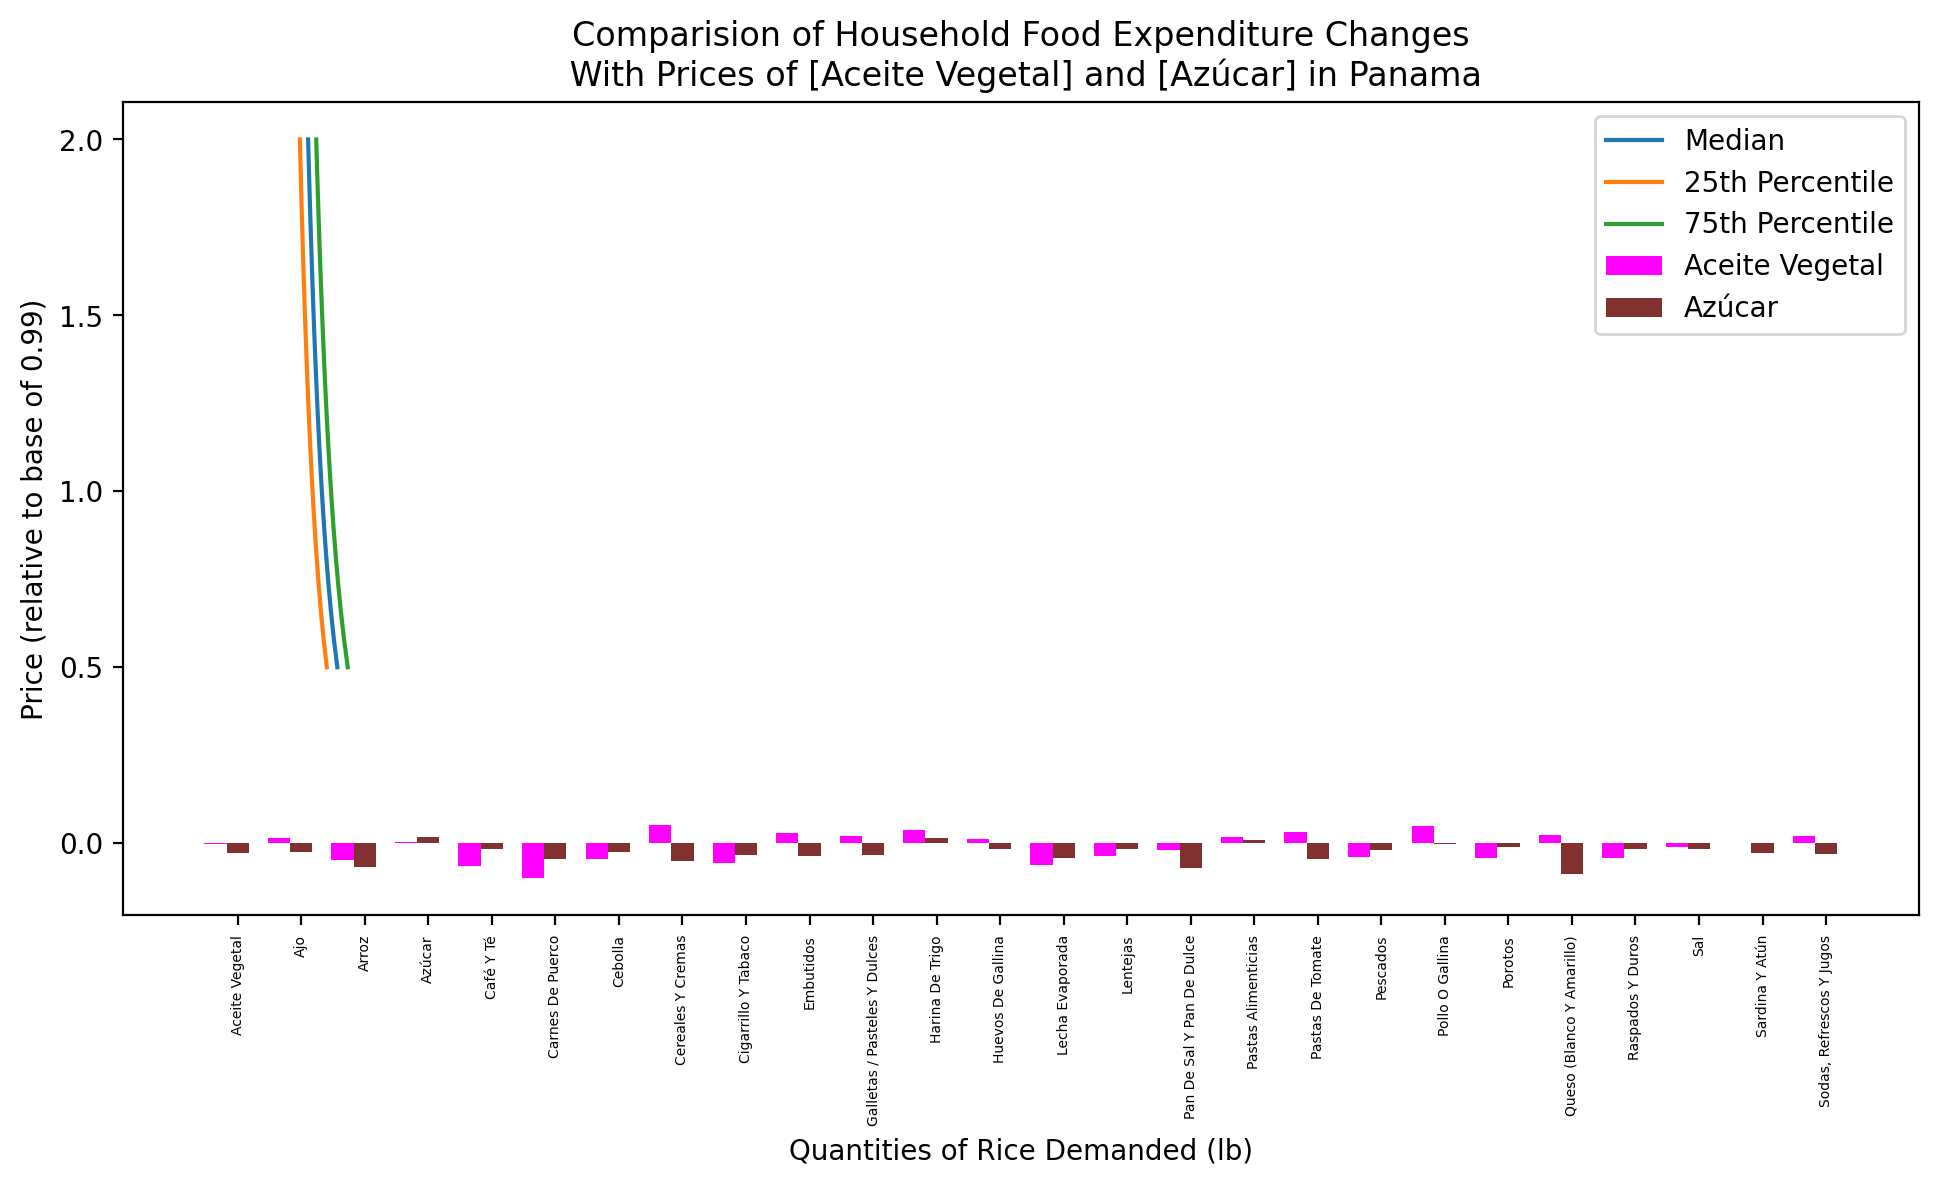

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# Demand for Rice for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale, label='Median')

# Demand for Rice for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale, label='25th Percentile')

# Demand for Rice for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale, label='75th Percentile')

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of Rice Demanded (lb)")
plt.legend()

plt.show()

<br>


## __[A] Construct Nutrient System__

* ### *Main Nutrient System Equation:*

<br>

$$
      N^j_{i} = A^j(p) + \beta_j w_i + \zeta^j_i.
$$
<br>

> $N^j_{i}$ : *__Nutrient amount on food $j$ of household $i$ .__*
> 
> $A^j(p)$ : *__Sub-function of price $p$ of food $j$. It captures the demand elasticity of food $j$ .__*
>
> $\beta_j w_i$ : *__Variable $w_i$ represents household wealth (budget). The coefficient $\beta_j$ indicates how changes in household budget affect household's nutrient intakes.__*
>
> $\zeta^j_i$ : *__The error term represents all sources of variation in the dependent variable ($y_{i}^j$) that are not explained by the independent variables included in regression function.__*

In [29]:
# Take the median of prices per pound of all regions in specific year
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    prices_per_lb = prices.T.groupby('t', axis=1).median().xs('pound', level='u')

prices_per_lb.columns = [1997,2003]  # prices_per_lb is derived from Dataframe "prices"

# Implied relative prices
p_result = np.exp(result.get_Ar())

In [30]:
# Generates an array of 20 evenly spaced numbers from 0.5 to 2.
scale = np.linspace(.5,2,20)

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

# Reference prices - Calculate the average price for each food item across all observations.
pbar = p_result.groupby(level='j').mean()

def my_prices(p0, p = pbar, j = 'Arroz'):
    """
    This changes the food prices of good j while holding other food prices unchanged
    
    p0 - The price you want to change
    p - The price dataframe you want to make changes
    j - The specific food that you want to make changes in their price.
    """
    p_copy = p.copy()
    p_copy.loc[j] = p0
    return p_copy

# xhat is the predicted expenditure on foods, and prices_per_lb is the food prices per pounds. 
# Then qhat is the predicted food quantities of each household
qhat = xhat.unstack('j').xs(1997, level = 't') / prices_per_lb[1997]

# Drop missing columns
qhat = qhat.loc[:, qhat.count() > 0]

In [31]:
def nutrient_demand(x, p):
    """
    This function computes nutrition as a function of prices and budget.
    
    x - A list of potential budget based on food expenditure
    p - The average price for each food item across all observations.
    """
    c = result.demands(x, p)
    # Create a new FCT and vector of consumption that only share rows in common:
    fct0,c0 = fct.align(c,axis=0,join='inner')
    # N is weekly nutrient amount of each household.
    N = fct0.T@c0  # The @ operator means matrix multiply
    N = N.loc[~N.index.duplicated()]
    return N

# Create a list of potential budget based on food expenditure
X = np.linspace(xref/5, xref*5, 50)

UseNutrients = ['Energía','Proteina','Fibra Diet. total','Vit. A Equiv. Retinol','Vit. C']

<br>

### 📈📊 *__Nutrient System Analytics [I] - Describe Nutrient Amount as A Function of Household Budget:__*

<br>

$$
      N^j_{i} = \beta_j w_i + \zeta^j_i.
$$

<br>

In [ ]:
df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('Logarithmic Budget')
ax.set_ylabel('Logarithmic Nutrient')
ax.set_title("Household Nutrient Amount Changes in Response to Budget Changes")

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*This graph illustrates how nutrient levels change in response to fluctuations in the average household budget.*__
* <span style = "color:#1FF30E">__*From a broad perspective, we observe that all nutrient levels increase alongside the household budget.*__
* <span style = "color:#1FF30E">__*However, upon closer examination, we notice that at lower budget levels, there is a significant spike in nutrient intake, but as the budget increases further, the rate of increase in nutrient levels diminishes. This indicates a diminishing marginal change in nutrient demand relative to budget.*__
* <span style = "color:#1FF30E">__*Additionally, when analyzing the slope of each nutrient, we observe that energy, protein, vitamin A, and vitamin C follow a similar trajectory of change, while fiber exhibits a more gradual increase with a shallower slope.*__

<br>

### 📈📊 *__Nutrient System Analytics [II] - Describe Nutrient Amount as A Function of Food Price:__*

<br>

$$
      N^j_{i} = A^j(p) + \zeta^j_i.
$$

<br>

In [ ]:
print("Please choose from the following:\n'Aceite Vegetal', 'Ajo', 'Arroz', 'Azúcar', 'Café Y Té', 'Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas', 'Cigarrillo Y Tabaco', 'Embutidos', 'Galletas / Pasteles Y Dulces', 'Harina De Trigo', 'Huevos De Gallina', 'Lecha Evaporada', 'Lentejas', 'Pan De Sal Y Pan De Dulce', 'Pastas Alimenticias', 'Pastas De Tomate', 'Pescados', 'Pollo O Gallina', 'Porotos', 'Queso (Blanco Y Amarillo)', 'Raspados Y Duros', 'Sal', 'Sardina Y Atún', 'Sodas, Refrescos Y Jugos'")
print("\n")
USE_GOOD = input("Please input the food name you would like to query (No quotation mark required): ")
print("\n")

scale = np.geomspace(.01,10,50)
ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T
ax = ndf.plot()
ax.set_xlabel('Logarithmic Price')
ax.set_ylabel('Logarithmic Nutrient')
ax.set_title(f"Household Nutrient Amount Changes in Response to Price Changes in [{USE_GOOD}]")

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*The graph depicts how nutrient levels respond to changes in the price of specific foods.*__
* <span style = "color:#1FF30E">__*Initially, there is a general trend of decreasing nutrient levels as food prices rise.*__
* <span style = "color:#1FF30E">__*However, a closer examination reveals nuances in this relationship. At lower price levels, there is a notable increase in nutrient intake, but as prices escalate further, the rate of nutrient level increase slows down. This suggests a diminishing marginal change in nutrient demand relative to food price.*__
* <span style = "color:#1FF30E">__*For instance, consider <u>Leche Evaporada (evaporated milk)</u>: as its price increases, nutrients such as energy, protein, vitamin A, and vitamin C experience substantial drops, particularly vitamin A. In contrast, the line representing fiber remains almost flat, indicating that the fiber content in this food remains relatively unaffected by price changes. This suggests that fiber content in this food is inelastic to price changes.*__
* <span style = "color:#f44336">__*From a policy standpoint, this implies that <u>Leche Evaporada</u> could be a strategic choice for adjusting people's vitamin A intake, but it may not be an effective proxy for regulating fiber intake.*__.

<br>


## __[A] Nutritional Challenges & Policy Goal__

### 📈📊 *__Nutritional Challenges Analytics [I] - Visualization:__*

In [ ]:
use = fct.index.intersection(qhat.columns)

# qhat is predicted food quantities of each household, and fct is the nutrition amount of each specific food. 
# Hence, we use qhat * fct to get the nutrient amount of each household.
nutrients = qhat[use]@fct.loc[use, :]

In [ ]:
# Define a mapping dictionary to rename columns in hh_characteristics DataFrame
column_mapping = {
    'Males 00-03': 'Males 00-03',
    'Females 00-03': 'Females 00-03',
    'Males 04-08': 'Males 04-08',
    'Females 04-08': 'Females 04-08',
    'Males 09-13': 'Males 09-13',
    'Females 09-13': 'Females 09-13',
    'Males 14-18': 'Males 14-18',
    'Females 14-18': 'Females 14-18',
    'Males 19-30': 'Males 19-30',
    'Females 19-30': 'Females 19-30',
    'Males 31-50': 'Males 31-50',
    'Females 31-50': 'Females 31-50',
    'Males 51-99': 'Males 51-99',
    'Females 51-99': 'Females 51-99',
    'log HSize': 'log HSize'
}

nutrient_translation = {'Energía':'Energy',
                       'Proteina': 'Protein',
                       'Fibra Diet. total' : 'Fiber',
                       'Ac. Folico' : 'Folate',
                       'Calcio' : 'Calcium',
                      'Carbo-hidratos' : 'Carbohydrate',
                      'Hierro': 'Iron',
                       'Fosforo' : 'Phosphorus',
                       'Vit. A Equiv. Retinol' : 'Vitamin A',
                      'Magnesio' : 'Magnesium',
                      'Niacina' : 'Niacin',
                      'Potasio' : 'Potassium',
                      'Vit. B12' : 'Vitamin B-12',
                      'Vit.B6' : 'Vitamin B-6',
                      'Vit. C' : 'Vitamin C',
                      'Zinc' : 'Zinc'}

nutrients_eng = nutrients.rename(columns = nutrient_translation)

# Rename columns in hh_characteristics DataFrame using the mapping dictionary
hh_characteristics_eng = HH_characteristics.rename(columns = column_mapping)

hh_characteristics_eng = hh_characteristics_eng[column_mapping.values()]

hh_characteristics_eng_select = hh_characteristics_eng[rdi.columns.tolist()]

In [ ]:
# hh_rdi is the recommended nutrient amount of each household
hh_rdi = hh_characteristics_eng_select@rdi.T

# Check recommended weekly intake
hh_rwi = hh_rdi * 7
use_nutrients = nutrients_eng.columns.intersection(hh_rwi.columns)

# nutrients_eng is weekly nutrient amount of each household.
# The ratio represents the actual VS. recommended nutrient amount
# Greater than one ---> actual amount exceeds the recommended one
nutrient_ratio = (nutrients_eng[use_nutrients] / hh_rwi[use_nutrients]).dropna()

In [ ]:
%matplotlib inline
print("Please choose from the following:\n'Energy', 'Protein', 'Carbohydrate', 'Fiber', 'Calcium', 'Phosphorus', 'Iron', 'Niacin', 'Vitamin C', 'Vitamin A', 'Potassium', 'Zinc', 'Magnesium', 'Vitamin B-12'")
print("\n")
USE_nutrient_name = input("Please input the nutrient name you would like to query (No quotation mark required): ")
print("\n")
USE_nutrient_name = str(USE_nutrient_name)
nutrient_ratio[USE_nutrient_name].hist(bins=100,range = (0,1))
plt.xlabel("Ratio")
plt.ylabel("Household Amount")
plt.title(f"Distribution of Households' [{USE_nutrient_name}] Ratio \n(Ratio = Actual Nutrient Amount / Recommended Nutrient Amount)")

# Add a red vertical line at x = 1.0
plt.axvline(x=1.0, color='red', linestyle='--', label='Nutrient Recommended Standard', linewidth=4)

# Add a blue vetical line for averayge
average_amount = nutrient_ratio.mean()[USE_nutrient_name]
plt.axvline(x=average_amount, color='#7AF30E', linestyle='-.', linewidth=3, label='Actual Average Amount')

plt.legend()
plt.show()

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*This histogram displays the distribution of nutrient ratios across households. The ratio is calculated by dividing the actual amount of a specific nutrient by the recommended amount.*__
* <span style = "color:#1FF30E">__*A ratio of 1 indicates that the actual nutrient intake matches the recommended intake, which is the ideal scenario denoted by the red line. Each bar's height represents the number of households corresponding to that particular ratio.*__
* <span style = "color:#1FF30E">__*The blue line represents the average ratio across all households.*__
* <span style = "color:#1FF30E">__*In the case of vitamin A, for example, the blue line is positioned noticeably to the left of the red line. This indicates that the majority of households have an insufficient intake of vitamin A relative to the recommended amount.*__
* <span style = "color:#f44336">__*Therefore, this observation highlights the focus of our policy efforts towards addressing inadequate vitamin A intake in households.*__

<br>

### 📈📊 *__Nutritional Challenge Analytics [II] - Nutritional Data Comparison:__*
<br>

* ### *To ensure a more precise comparison of nutrients, we will create a DataFrame for it.*

In [ ]:
actual_nutrients = nutrients_eng[use_nutrients].mean()
recommended_nutrients = hh_rwi[use_nutrients].mean()

# Create a DataFrame from the two series
df = pd.DataFrame({'Actual Nutrients': actual_nutrients, 'Recommended Nutrients': recommended_nutrients})

# Add a column for the difference
df['Difference'] = df['Actual Nutrients'] - df['Recommended Nutrients']

# Add a column for marking excessive or insufficient
df['Status'] = pd.Series(['Excessive' if diff > 0 else 'Insufficient' for diff in df['Difference']], index=df.index)

# Function to apply cell styling based on status
def color_cell(val):
    color = 'red' if val == 'Excessive' else 'skyblue'
    return 'background-color: %s' % color

# Apply styling to the 'Status' column
styled_df = df.style.map(color_cell, subset=['Status'])

# Display the styled DataFrame
styled_df

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*From the table above, you can clearly discern the comparison between the actual and recommended nutrient amounts in precise numerical values. It allows for a straightforward assessment of the disparities, indicating whether the actual intake exceeds or falls short of the recommended values and by how much. This information is crucial for informing policy decisions regarding specific nutrient adequacy or insufficiency.*__

<br>


## __[B] Policy Options__

<br>

#### Policy Goals 

<br>



<br>


## __[C] Policy Cost__

<br>


## __[C] Value of Technical Innovation__


<br>

<br>

